# Analyses of mouse clusters


In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
import pandas as pd
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go 

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from clustering_functions import revert_to_original, get_ballistic, get_no_resp

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Get data

In [2]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [3]:
# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
trials_filename = str(results_path + 'cluster_per_trial01-09-2025')
trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
mouse_filename = str(results_path + 'cluster_per_mouse01-09-2025')
mouse_clusters = pd.read_parquet(mouse_filename, engine='pyarrow')

## Plot mouse cluster features

In [4]:
mean_cluster_mice = pd.DataFrame(mouse_clusters.groupby(['mouse_cluster', 'cluster'])['relative_frequency'].mean()).reset_index()


In [7]:
if mouse_filename == str(results_path + 'cluster_per_mouse01-09-2025'):

    plt_vars = ['Right ballistic', 'Right choice, low contrast','Long pre-quiescence', 
                'Left ballistic', 'Left, long pre-quiescence', 'Long reaction'] 
    unique_clusters = [3, 2, 1, 0, 5, 4]
    new_dict = {3:0, 0:3, 2:1, 1:2, 4:5, 5:4}
else:
    plt_vars = ['Right ballistic', 'Left ballistic', 'Right choice, low contrast','Long pre-quiescence', 
            'Long reaction','Left, long pre-quiescence'] 
    unique_clusters = [3, 0, 2, 1, 4, 5]
    new_dict = {3:0, 0:1, 2:2, 1:3, 4:4, 5:5}

# {unique: key for unique, key in zip(state_labels, int_state)}
mapping = {
    cluster: label
    for cluster, label in zip(unique_clusters, plt_vars)
}
mapping
replace_func = np.vectorize(mapping.get)

replace_func = np.vectorize(new_dict.get)
mean_cluster_mice['new_clusters'] = mean_cluster_mice['cluster'].copy()
mean_cluster_mice['new_clusters'] = replace_func(mean_cluster_mice['cluster'])


In [8]:
mean_cluster_mice['label'] = mean_cluster_mice['cluster'].copy()
mean_cluster_mice['label'] = replace_func(mean_cluster_mice['label'])

mean_cluster_mice.sort_values(by='label')

# Custom order (array) for the 'name' column
custom_order = ['Right ballistic','Accurate, long pre-quiescence','Long reaction', 'Left ballistic',
            'Left non-ballistic','Right non-ballistic'] 

# Convert the 'name' column to a categorical type with the specified order
mean_cluster_mice['label'] = pd.Categorical(mean_cluster_mice['label'], categories=custom_order, ordered=True)


In [9]:

plt.rcParams.update({'font.size': 16})

# plot star plot for comparison 
fig = go.Figure() 
fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_mice.sort_values(by='new_clusters').loc[mean_cluster_mice['mouse_cluster']==0, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Mouse cluster 0' 
)) 
fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_mice.sort_values(by='new_clusters').loc[mean_cluster_mice['mouse_cluster']==1, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Mouse cluster 1'
)) 

fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_mice.sort_values(by='new_clusters').loc[mean_cluster_mice['mouse_cluster']==2, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Mouse cluster 2'
)) 
  
fig.update_layout( 
  polar=dict(
        angularaxis=dict(
            tickfont=dict(size=16)  # Set the font size of the theta labels
        ),
    radialaxis=dict( 
      visible=True,
      tickfont=dict(size=16)
          )), 
  
  showlegend=True
)  #     template = 'plotly_dark', 

# plt.savefig(file_path+'star_plots_mice.svg', format="svg")
fig.write_image(file_path + 'star_plots_mice.svg')

fig.show() 

## Get trial cluster centroids

In [43]:
data_2d = np.array(trial_clusters[['sample', 'UMAP1', 'UMAP2']].drop_duplicates()[['UMAP1', 'UMAP2']])
kmeans_trials = KMeans(n_clusters=6, random_state=2024)
kmeans_trials.fit(data_2d)
y_kmeans_trials = kmeans_trials.predict(data_2d)
# Plot the centroids
centroids = kmeans_trials.cluster_centers_

array([[ 4.3361745 , 11.730347  ],
       [-3.144758  , 16.509695  ],
       [ 0.9379882 ,  0.81155765],
       ...,
       [ 4.89226   , 11.003257  ],
       [ 5.1222887 , 10.409764  ],
       [ 7.5302434 ,  1.6164372 ]], dtype=float32)

/tmp/ipykernel_31383/3529105746.py:19: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

/tmp/ipykernel_31383/3529105746.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



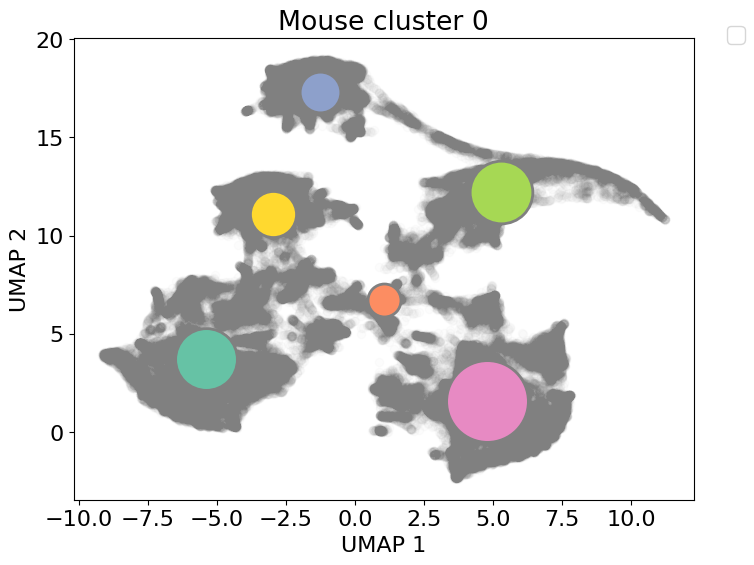

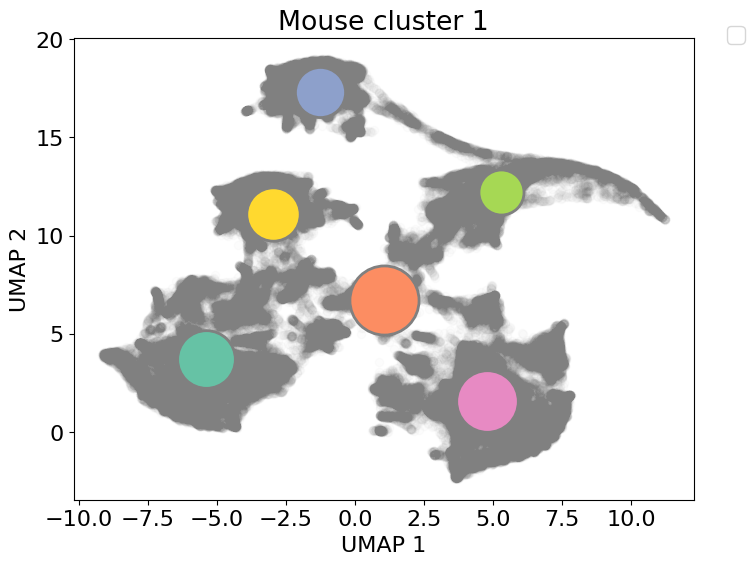

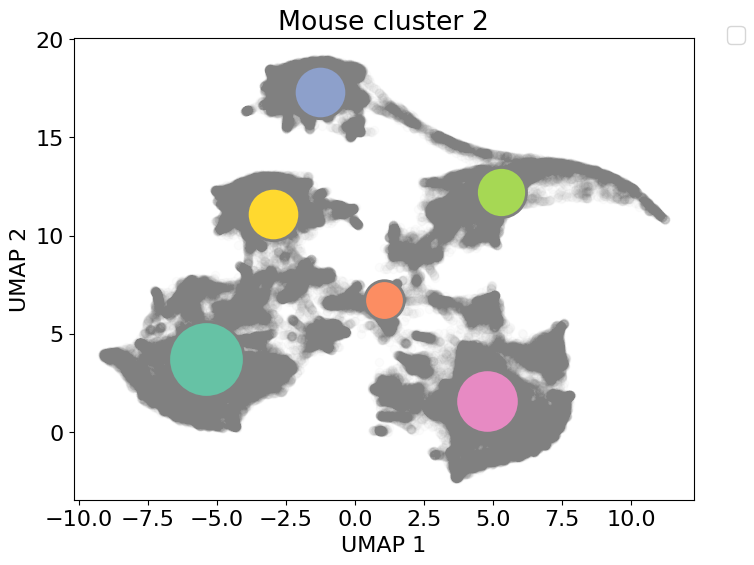

In [48]:
for i in [0, 1, 2]:

    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 16})
    colors = sns.color_palette("Set2", 8)

    scatter = plt.scatter(
        data_2d[:, 0],
        data_2d[:, 1],
        alpha=0.02,
        c='grey'  # Choose a colormap
)   

    # Plot the centroids
    for c, cent in enumerate(centroids):
        mean = mean_cluster_mice.loc[(mean_cluster_mice['mouse_cluster']==i) & 
                                        (mean_cluster_mice['cluster']==c), 'relative_frequency']
        
        plt.scatter(centroids[c, 0], centroids[c, 1], edgecolor='grey', linewidth=2, c=colors[c], alpha=1, s=mean*10000)


    plt.title('Mouse cluster ' + str(i))
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

Text(0.5, 0, 'Mouse cluster')

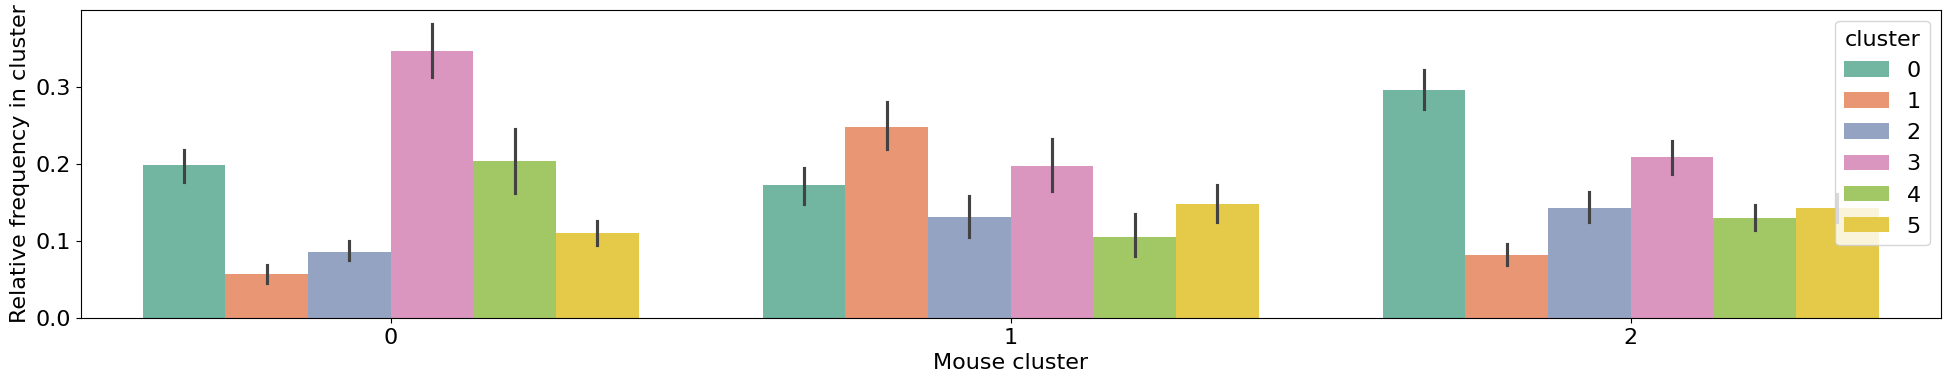

In [39]:
fig, ax = plt.subplots(figsize=(24, 4))
sns.barplot(x='mouse_cluster', y='relative_frequency', hue='cluster', data=mouse_clusters, palette='Set2')
plt.ylabel('Relative frequency in cluster')
plt.xlabel('Mouse cluster')

## Merge trial info and mouse clusters

## Get learning data

In [10]:
mouse_trials_df = trial_clusters.merge(mouse_clusters[['mouse_name', 'mouse_cluster']])
new_df = pd.DataFrame(mouse_trials_df.groupby(['mouse_name', 'mouse_cluster', 'session'])['reaction', 'response', 
                                                                                          'elongation', 'correct', 'ballistic'].mean()).reset_index()
# new_df = pd.DataFrame(new_df.groupby(['mouse_name', 'mouse_cluster'])['reaction', 'response', 'elongation', 'correct', 'ballistic'].mean()).reset_index()

/tmp/ipykernel_41936/800185341.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



/tmp/ipykernel_31383/1986622969.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_31383/1986622969.py:2: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



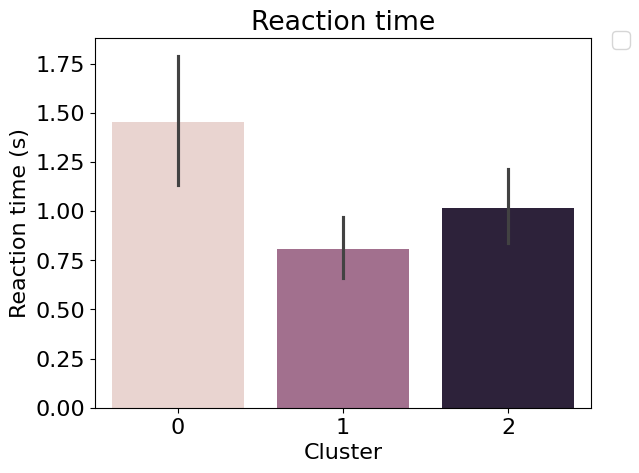

/tmp/ipykernel_31383/1986622969.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_31383/1986622969.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



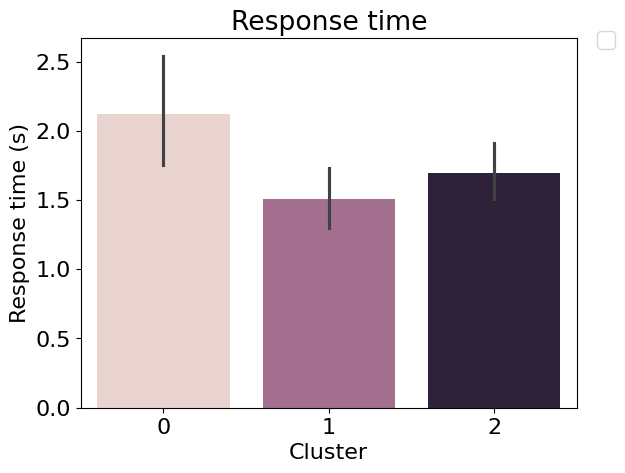

/tmp/ipykernel_31383/1986622969.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_31383/1986622969.py:20: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



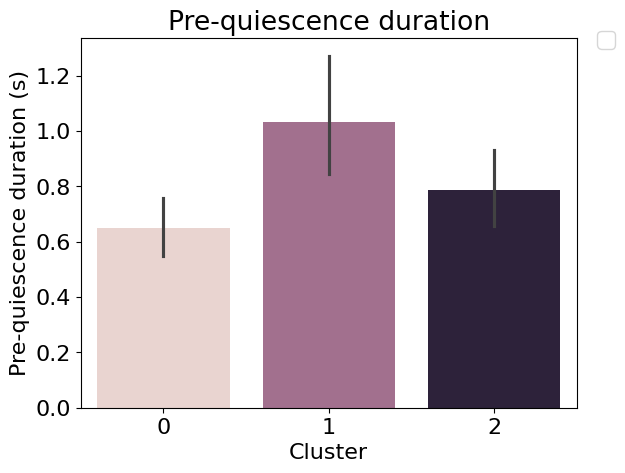

/tmp/ipykernel_31383/1986622969.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_31383/1986622969.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



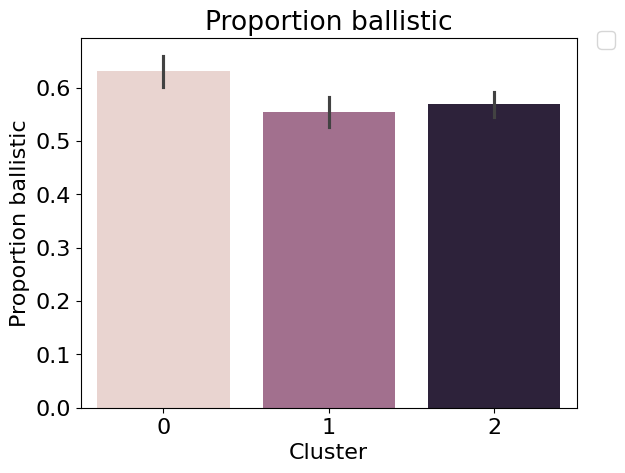

/tmp/ipykernel_31383/1986622969.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_31383/1986622969.py:38: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



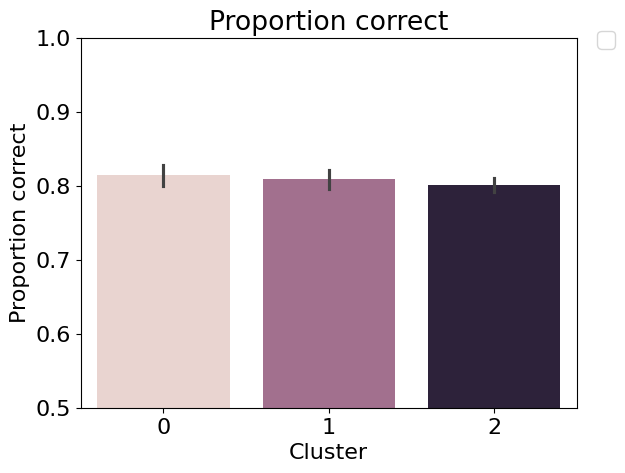

In [67]:
sns.barplot(x='mouse_cluster', y='reaction', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Reaction time (s)')
plt.xlabel('Cluster')
plt.savefig(file_path+'reaction_mouse.svg', format="svg")

plt.show()

sns.barplot(x='mouse_cluster', y='response', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.savefig(file_path+'response_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='elongation', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Pre-quiescence duration (s)')
plt.savefig(file_path+'elongation_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='ballistic', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic')
plt.savefig(file_path+'ballistic_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='correct', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion correct')
plt.ylabel('Proportion correct')
plt.savefig(file_path+'correct_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.ylim([.5, 1])
plt.show()

# use_data = df_cluster.copy()
# use_data.loc[use_data['choice']=='left', 'choice'] = 1
# use_data.loc[use_data['choice']=='right', 'choice'] = 0
# sns.barplot(x='mouse_cluster', y='choice', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Choice')
# plt.ylabel('Proportion choice left')
# plt.xlabel('Cluster')
# plt.show()



## Plot per hue

(0.0, 5.5)

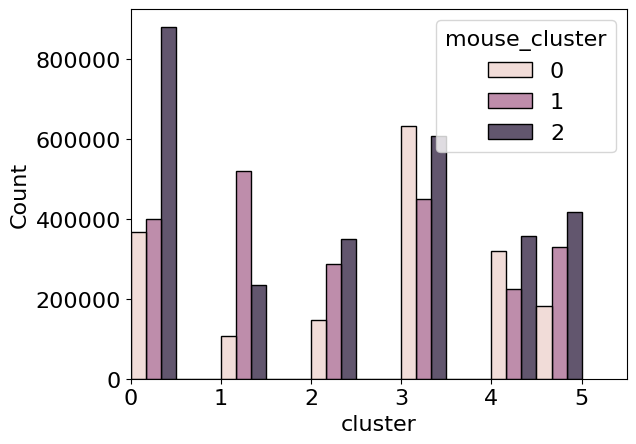

In [94]:
sns.histplot(x='cluster', data=mouse_trials_df, hue='mouse_cluster', binwidth=.5, multiple='dodge')
plt.xlim([0, 5.5])

/tmp/ipykernel_31383/3800886313.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



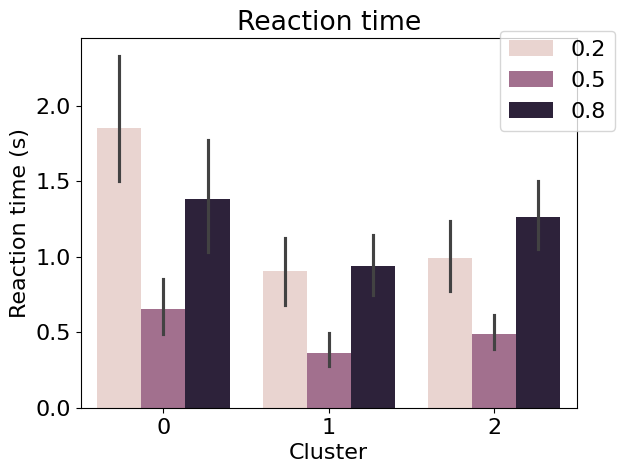

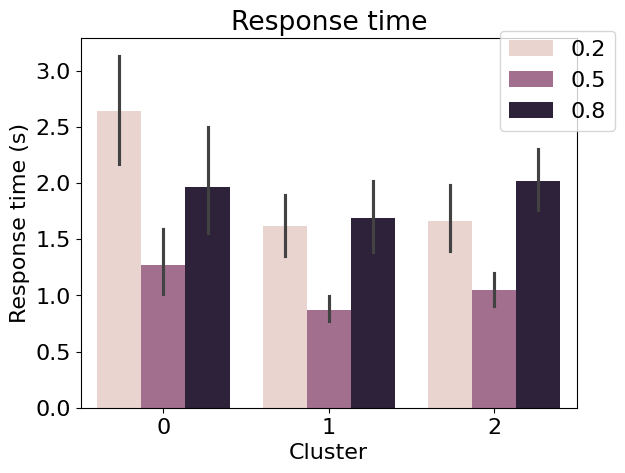

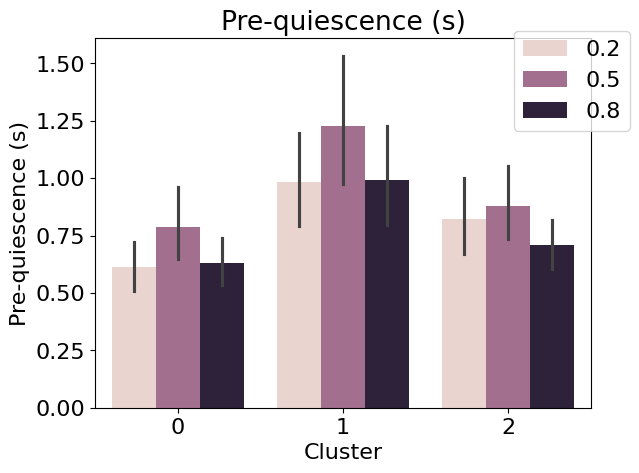

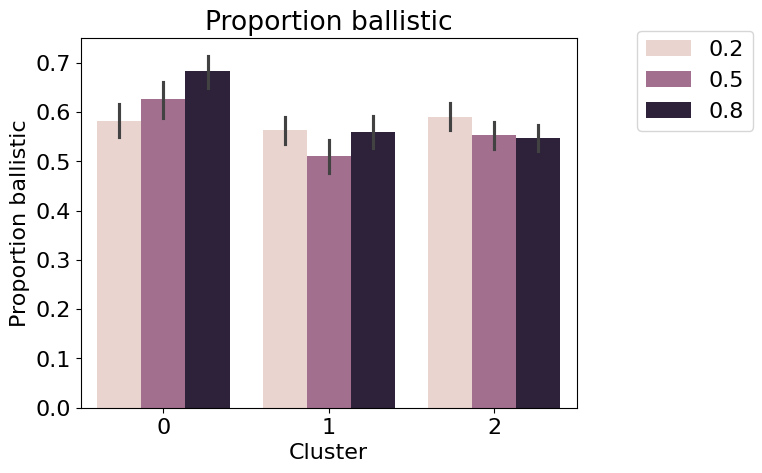

In [85]:
hue = 'block'
use_df = pd.DataFrame(mouse_trials_df.groupby(['mouse_name', 'mouse_cluster', 'session', hue])['reaction', 'response', 'elongation', 'ballistic'].mean()).reset_index()


sns.barplot(x='mouse_cluster', y='reaction', hue=hue, data=use_df)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Reaction time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='response', hue=hue, data=use_df)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='elongation', hue=hue, data=use_df)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence (s)')
plt.ylabel('Pre-quiescence (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='ballistic', hue=hue, data=use_df)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic')
plt.xlabel('Cluster')
plt.show()




In [ ]:
# Perform two-sample t-test

group_1 = new_df.loc[new_df['mouse_cluster']==0, 'ballistic']
group_2 = new_df.loc[new_df['mouse_cluster']==2, 'ballistic']
t_stat, p_value = ttest_ind(group_1, group_2)
print(f"t-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

t-statistic: 2.703
P-value: 0.010


In [11]:

data_path =  '/home/ines/repositories/representation_learning_variability/DATA/'
os.chdir(data_path)
learning_df = pd.read_csv('learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()
df = new_df.merge(learning_times, on='mouse_name')

/tmp/ipykernel_41936/3565219939.py:3: DtypeWarning:

Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.



In [17]:
mouse_learning = mouse_clusters.merge(learning_times, on='mouse_name')

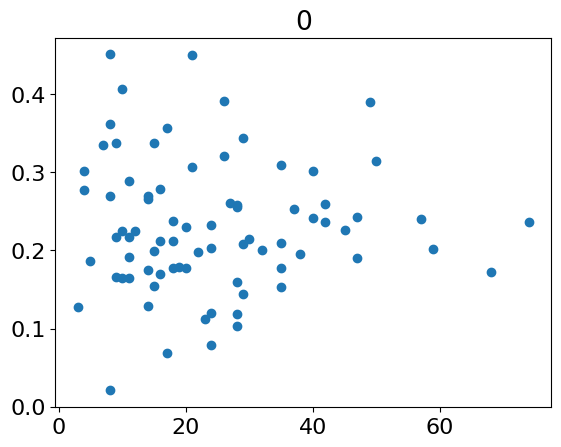

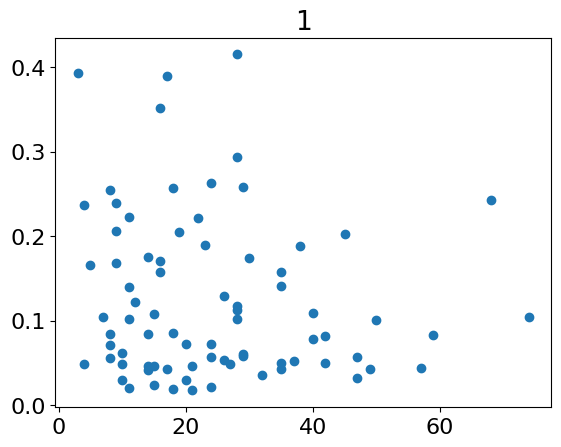

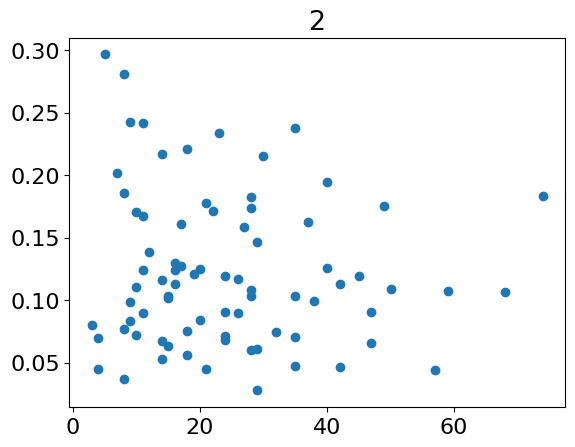

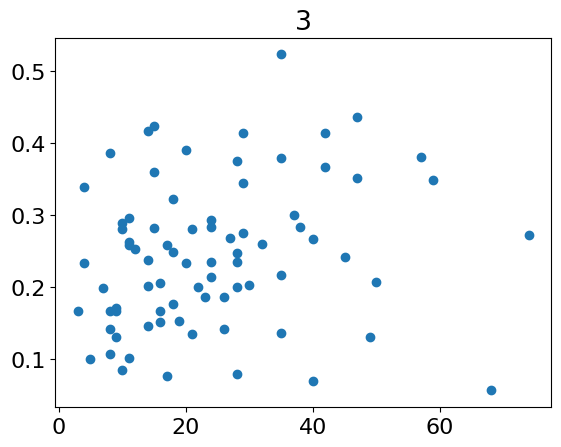

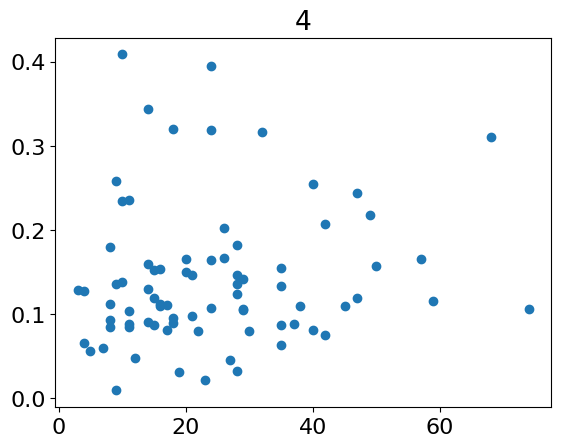

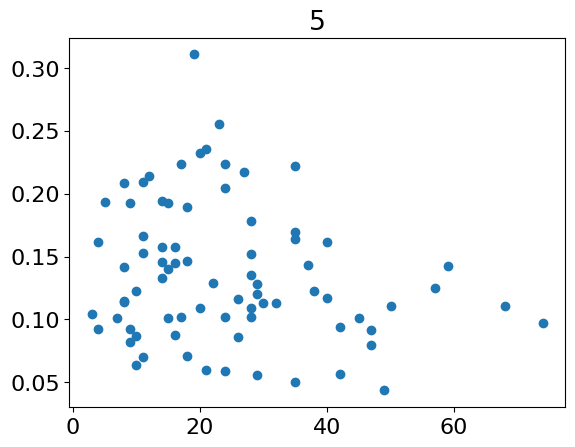

In [27]:
mouse_learning
for c, cluster in enumerate(mouse_learning['cluster'].unique()): 
    use_data = mouse_learning.loc[mouse_learning['cluster']==cluster]
    # use_data['training_time'] = np.log(use_data['training_time'])
    plt.scatter(y='relative_frequency', x='training_time', data=use_data)
    plt.title(cluster)
    plt.show()

                     sum_sq     df         F    PR(>F)
mouse_cluster    271.123292    1.0  1.467124  0.227168
Residual       38623.028367  209.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -5.5374 0.0681 -11.3924 0.3175  False
     0      2  -3.5741 0.2901  -9.1761 2.0278  False
     1      2   1.9633 0.6326  -3.1124  7.039  False
----------------------------------------------------


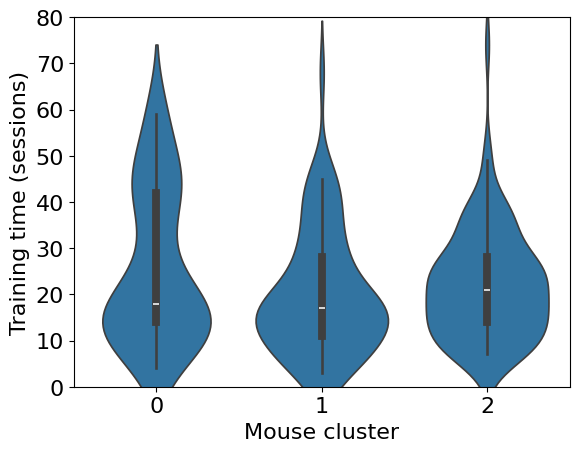

P-value for KW: 0.237
         0         1         2
0  1.00000  0.316760  1.000000
1  0.31676  1.000000  0.661891
2  1.00000  0.661891  1.000000


In [61]:

var_1 = 'training_time ~ mouse_cluster'
var = 'training_time'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()
model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['mouse_cluster'], alpha=0.05)

print(tukey)
plt.rcParams.update({'font.size': 16})
sns.violinplot(x='mouse_cluster', y=var, data=data)
plt.xticks([0, 1, 2], [0, 1, 2])
plt.ylim([0, 80])
plt.xlabel('Mouse cluster')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
plt.savefig(file_path+'training_time.svg', format="svg")

plt.show()


group_1 = df.loc[df['mouse_cluster']==0, var]
group_2 = df.loc[df['mouse_cluster']==1, var]
group_3 = df.loc[df['mouse_cluster']==2, var]

stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='mouse_cluster', p_adjust='bonferroni')
print(posthoc)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


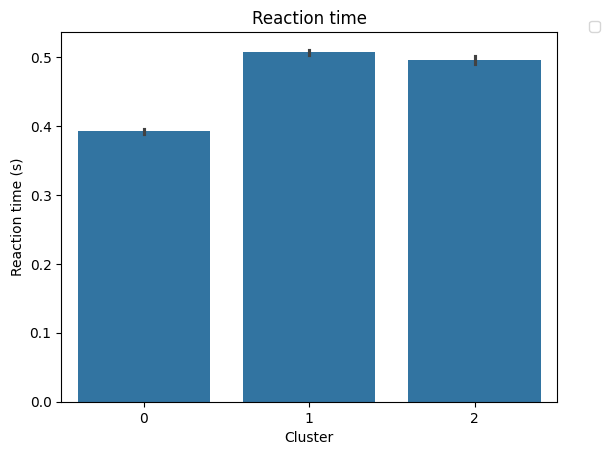

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


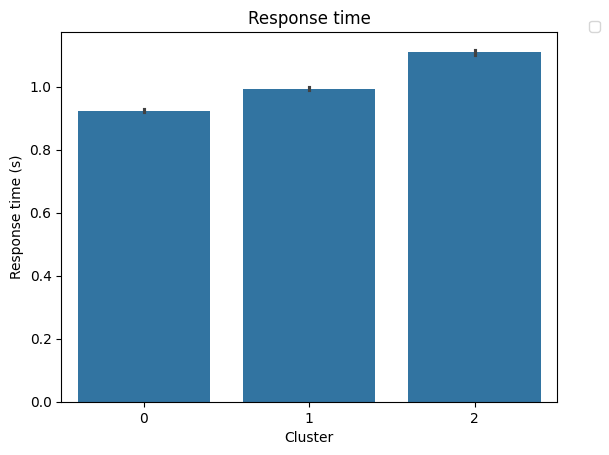

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


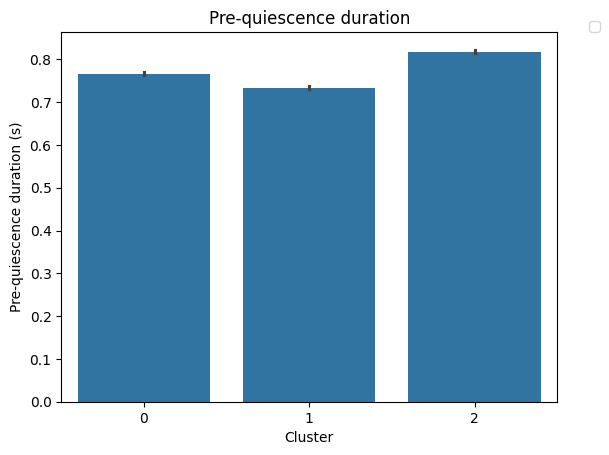

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


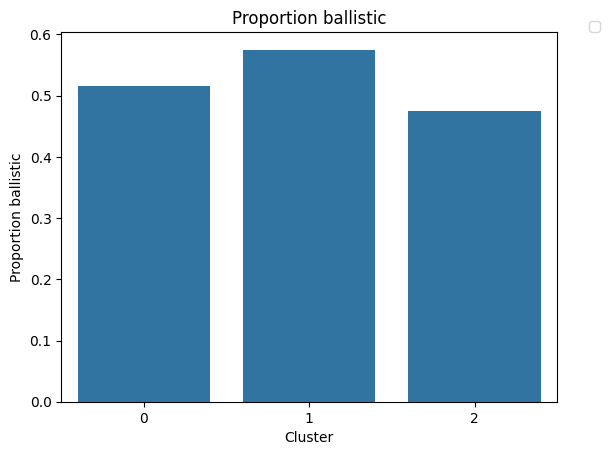

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


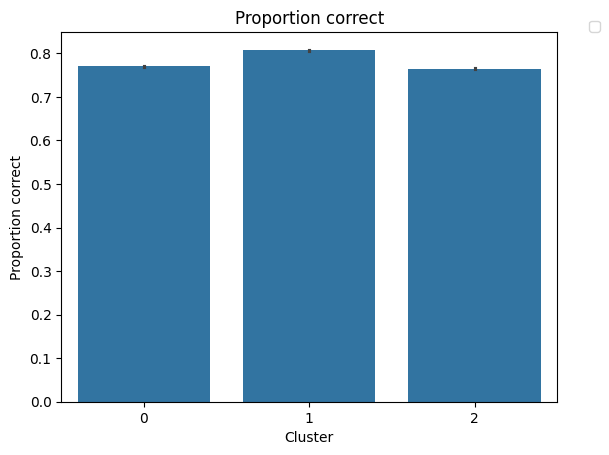

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


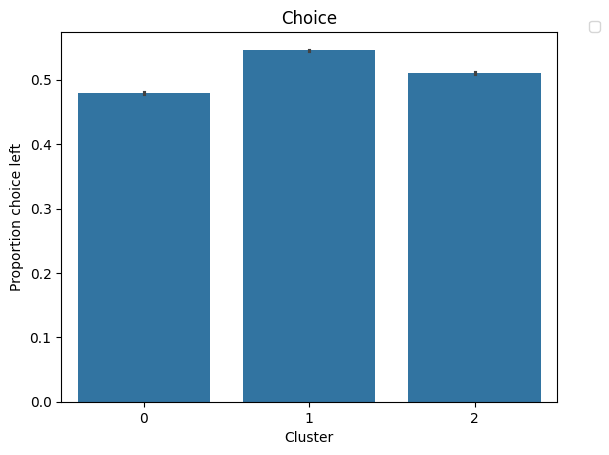

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


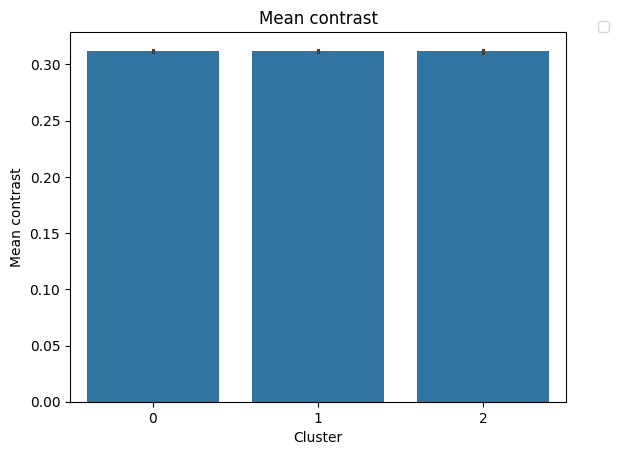

In [49]:
sns.barplot(x='cluster', y='reaction', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Reaction time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='response', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='elongation', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Pre-quiescence duration (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='ballistic', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='correct', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion correct')
plt.ylabel('Proportion correct')
plt.xlabel('Cluster')
# plt.ylim([.6, .9])
plt.show()

use_data = df_cluster.copy()
use_data.loc[use_data['choice']=='left', 'choice'] = 1
use_data.loc[use_data['choice']=='right', 'choice'] = 0
sns.barplot(x='cluster', y='choice', data=use_data)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Choice')
plt.ylabel('Proportion choice left')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='contrast', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Mean contrast')
plt.ylabel('Mean contrast')
plt.xlabel('Cluster')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


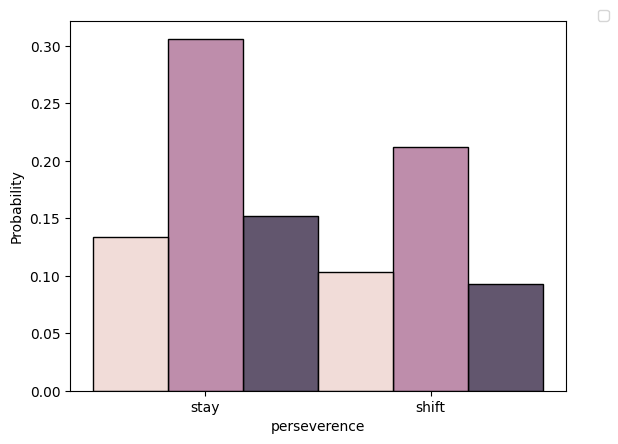

In [ ]:
sns.histplot(x='perseverence', hue='cluster', data=df_cluster, stat='probability', multiple='dodge')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('')
plt.show()


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering/clustering_functions.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



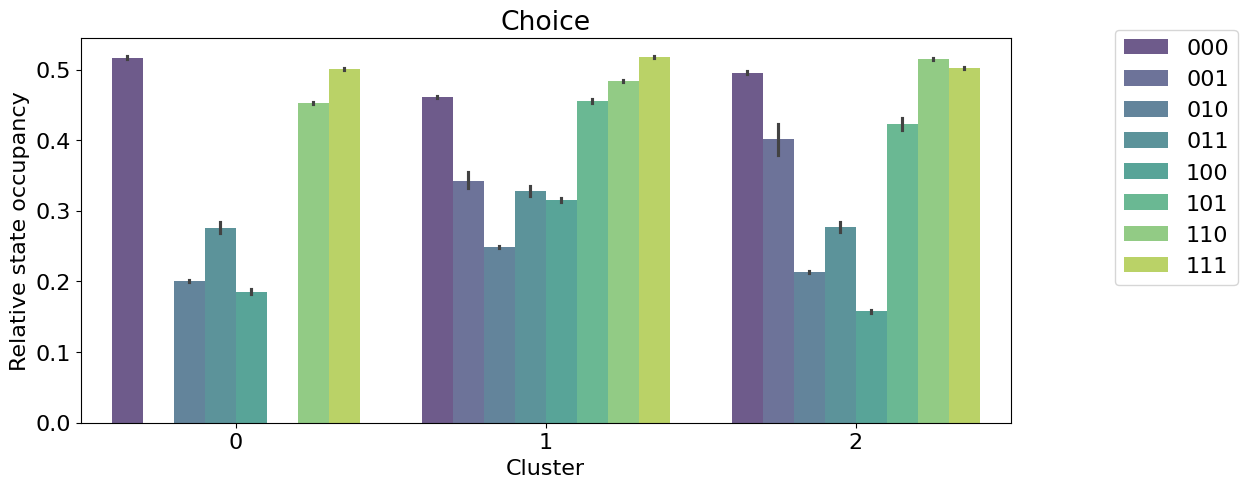

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering/clustering_functions.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



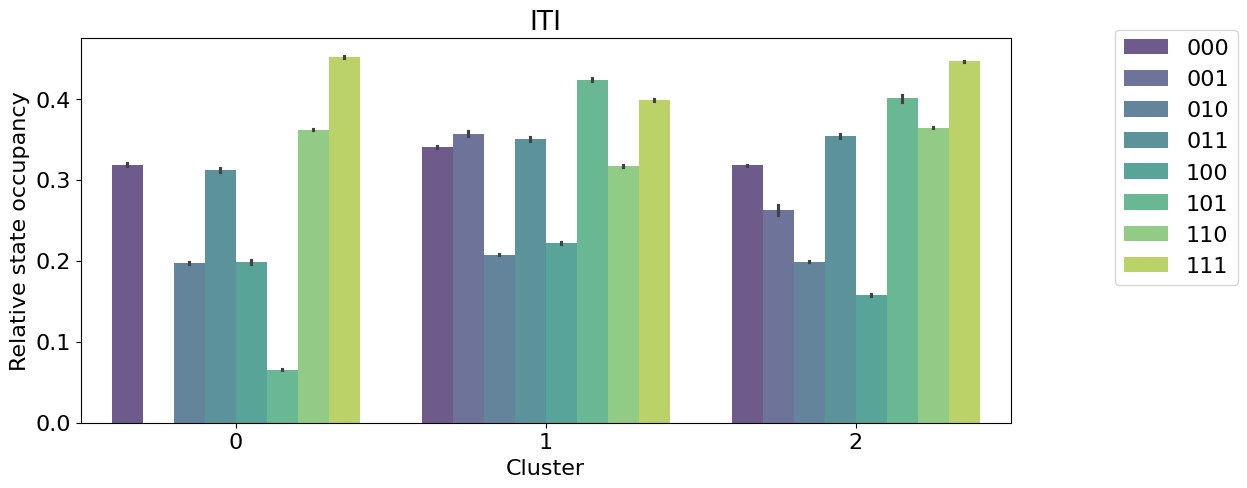

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering/clustering_functions.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



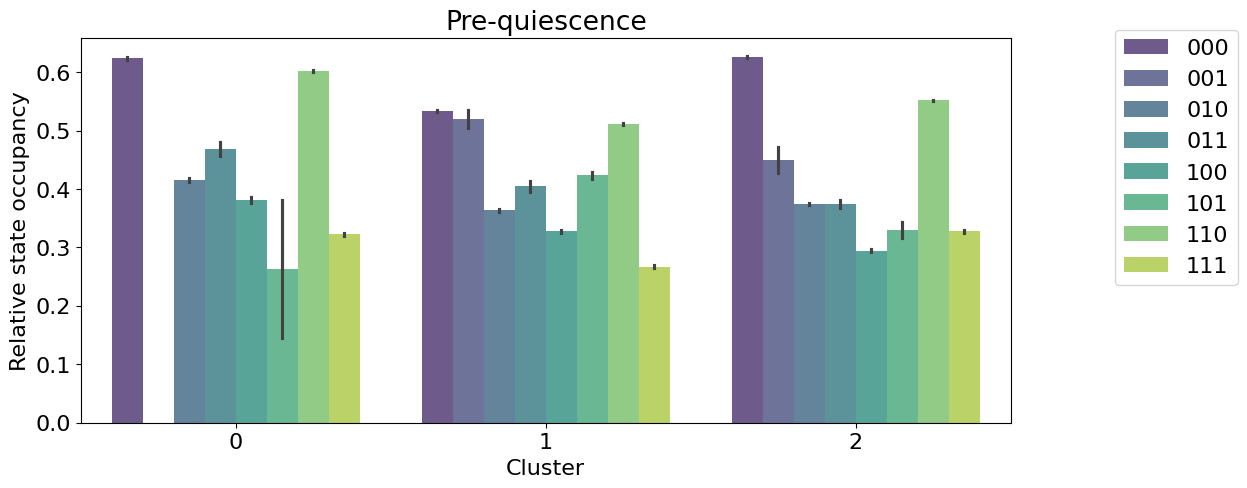

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering/clustering_functions.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



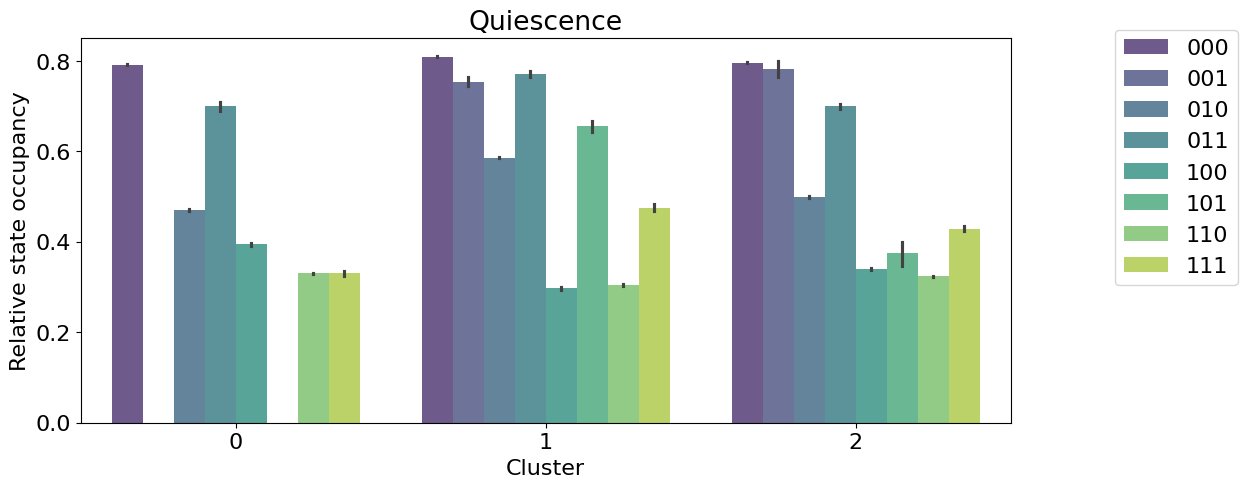

In [95]:
for e, epoch in enumerate(mouse_trials_df['broader_label'].unique()):
    use_data = mouse_trials_df.loc[mouse_trials_df['broader_label']==epoch]
    use_data = revert_to_original(use_data)
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(hue='original_states', y='relative_frequency', x='mouse_cluster', alpha=0.8,
                hue_order = ['000', '001', '010', '011', '100', '101', '110','111'], data=use_data, palette='viridis')
    plt.xlabel('Cluster')
    plt.ylabel('Relative state occupancy')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

## Plot ballistic stats per cluster

ValueError: Could not interpret value `ballistic` for `hue`. An entry with this name does not appear in `data`.

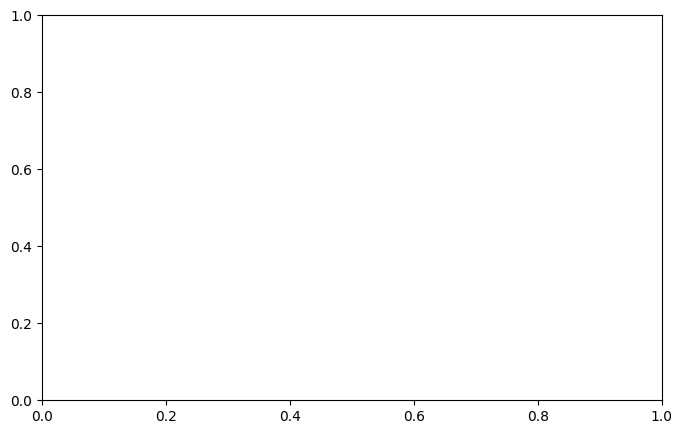

In [ ]:

labels = ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI']
colors = sns.color_palette('tab10')[0:2]
count['broader_label'] = pd.Categorical(count['broader_label'], categories=labels)
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(x='broader_label', y='count', data=count, hue='ballistic')
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')
# plt.xticks(rotation=45, ha='right')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()
# except:

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


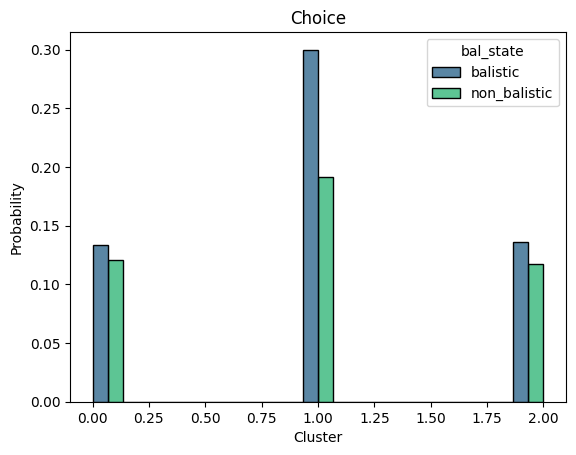

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


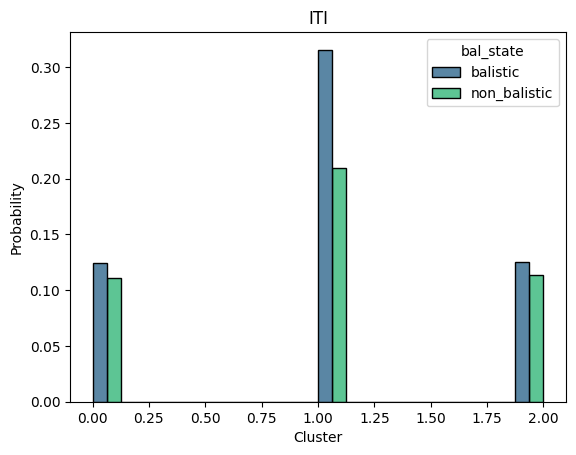

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


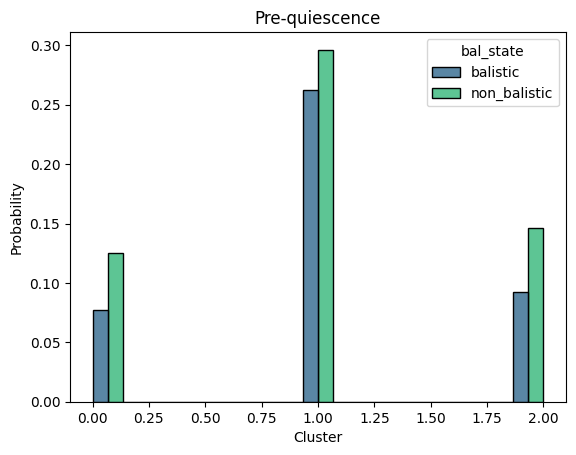

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


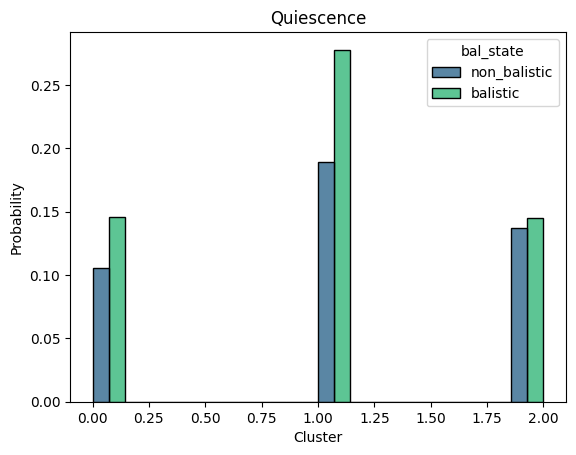

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


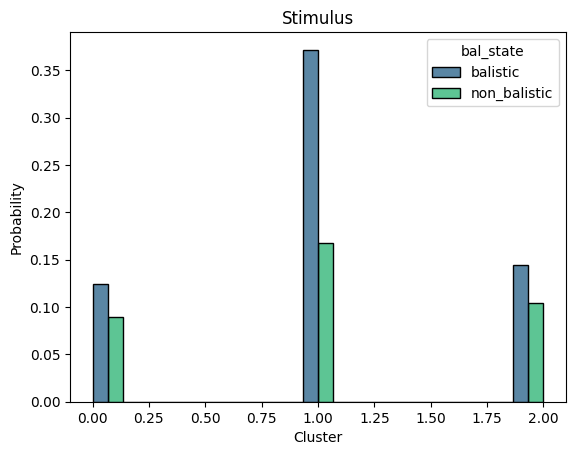

In [ ]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    use_data = get_ballistic(use_data)
    sns.histplot(hue='bal_state', x='cluster', alpha=0.8,data=use_data, stat='probability', multiple='dodge', palette='viridis')
    plt.xlabel('Cluster')
    # plt.ylabel('Proportion ballistic')
    # plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

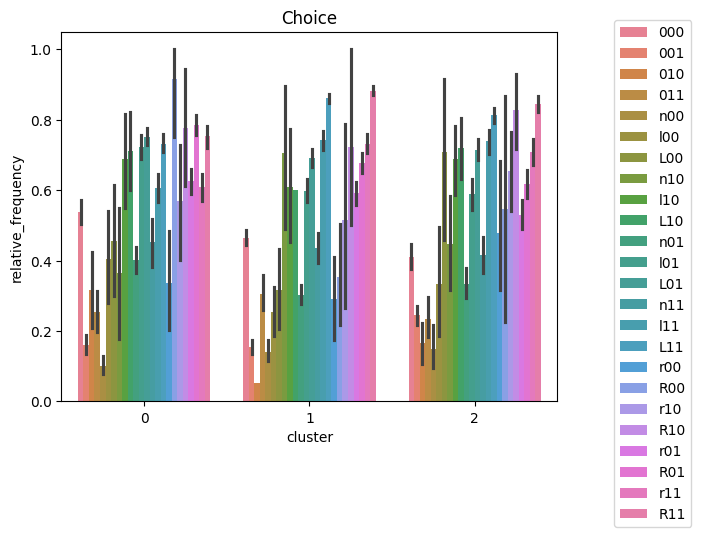

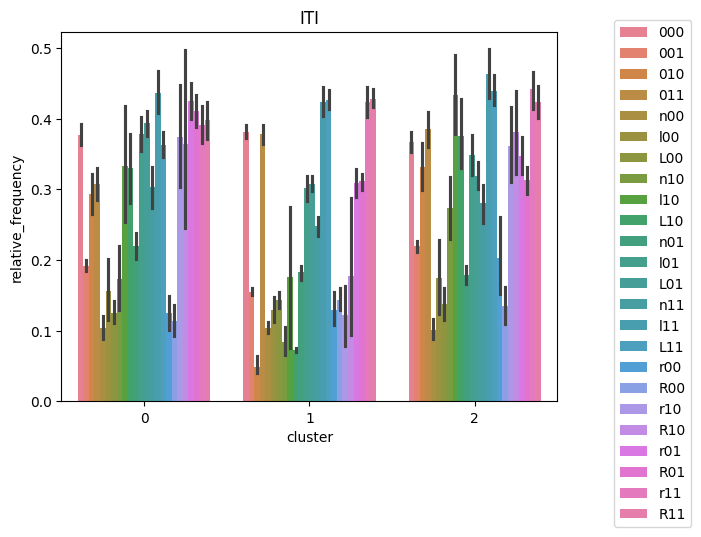

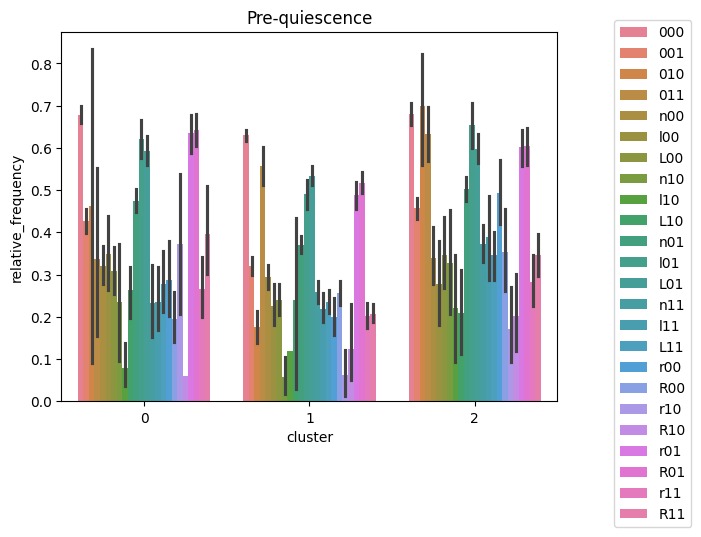

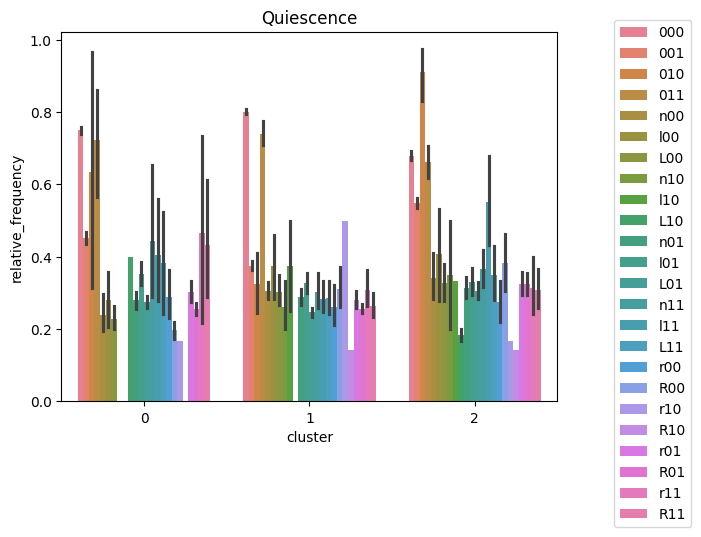

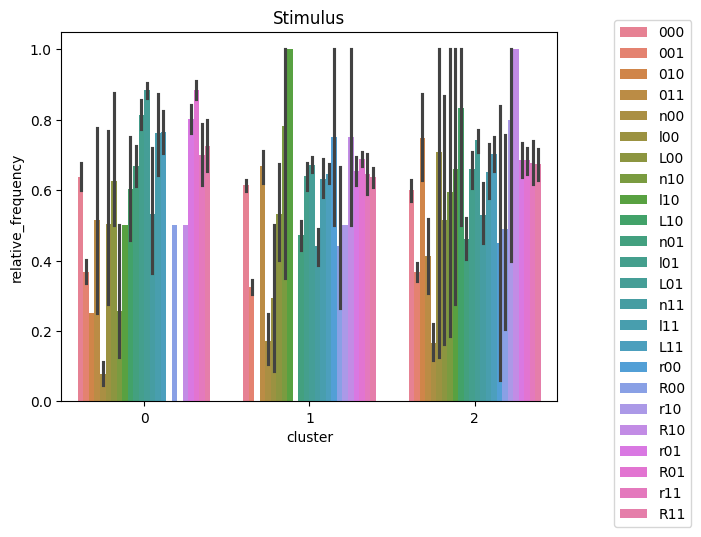

In [ ]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='cluster', 
                hue_order = ['000', '001', '010', '011', 'n00', 'l00', 'L00',
                             'n10', 'l10', 'L10', 'n01', 'l01', 'L01', 'n11', 'l11', 'L11',
                             'r00', 'R00', 'r10', 'R10', 'r01', 'R01', 'r11', 'R11'
                             ], data=use_data)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


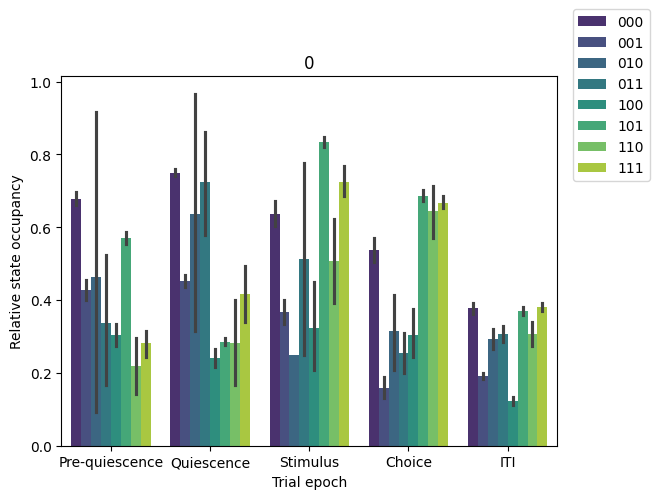

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


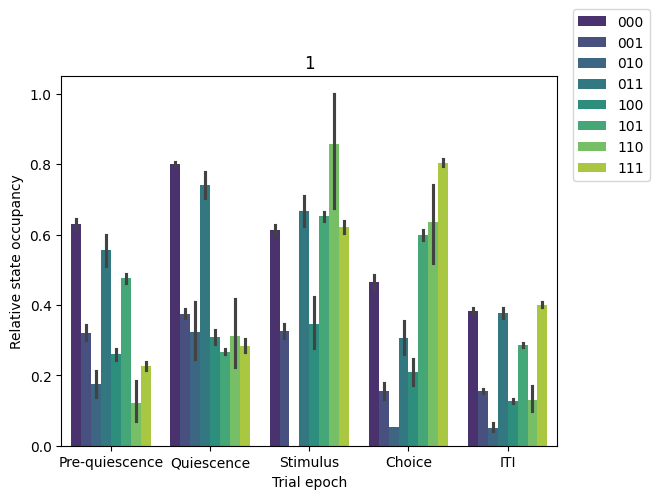

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


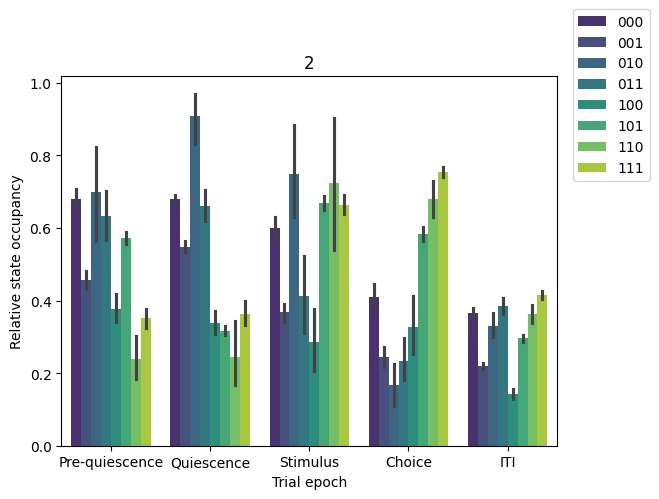

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


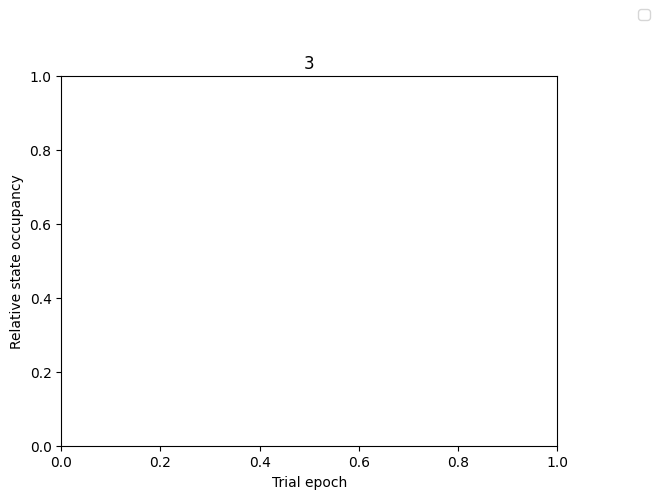

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


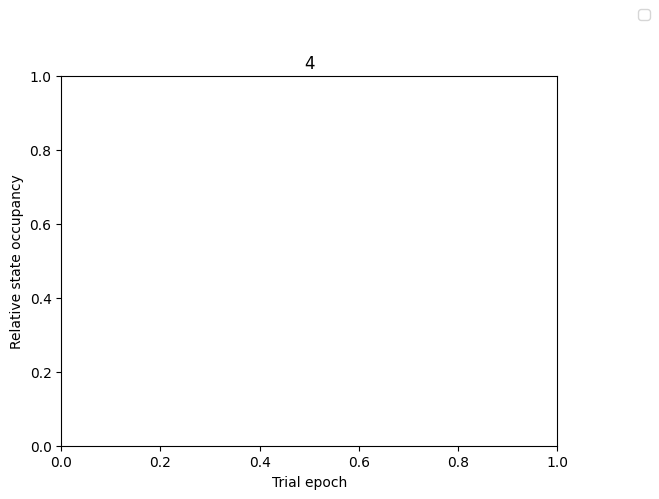

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


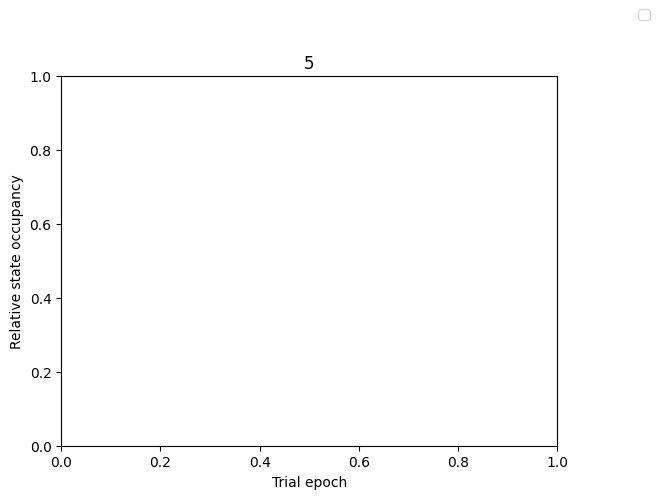

In [ ]:
for c, cluster in enumerate(range(6)):
    use_data = df_cluster.loc[df_cluster['cluster']==cluster]
    use_data = revert_to_original(use_data)
    sns.barplot(x='broader_label', y='relative_frequency', hue='original_states', 
                order=['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], 
                hue_order = ['000', '001', '010', '011', '100', '101', '110','111'], data=use_data, palette='viridis')
    plt.xlabel('Trial epoch')
    plt.ylabel('Relative state occupancy')
    plt.legend(bbox_to_anchor=(1.2, 1.2))
    plt.title(cluster)
    plt.show()